In [73]:
from scipy.optimize import ridder
import torch
import matplotlib.pyplot as plt
from Gibbs import generate_sw_tuples_batch
from MINE import MINE
from tqdm import tqdm
from torch.autograd import Variable
import numpy as np

import random
import os
seed = 1
def seed_torch(seed=1029):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False
	torch.backends.cudnn.deterministic = True
seed_torch(seed)

p_current = 4 #p值
sample_size = 50000 #用来估计的样本数
model = MINE(6, p_current)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
plot_loss = []

import json
with open('data/gibbs_data_p_is_{0}.json'.format(p_current), 'r') as datafile:
    data = json.load(datafile)
len(data)

50000

In [74]:

model=torch.load('./model_e6000.pth',map_location='cpu')

#model = torch.load('./model_ori6000.pth')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)

MINE(
  (fc1): Linear(in_features=6, out_features=16, bias=True)
  (fc2): Linear(in_features=4, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


array(-96.75567, dtype=float32)

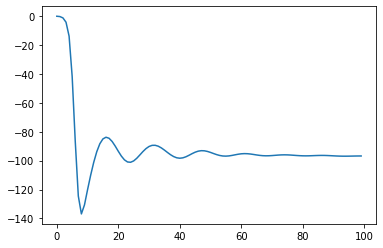

In [75]:

S = np.array([data[i]['S'][0] for i in range(len(data))][0:sample_size])
w = np.array([data[i]['w'] for i in range(len(data))][0:sample_size])
w_shuffle = np.random.permutation(w)
S_sample = Variable(torch.from_numpy(S).type(torch.FloatTensor), requires_grad=True)
w_sample = Variable(torch.from_numpy(w).type(torch.FloatTensor), requires_grad=True)
w_shuffle_sample = Variable(torch.from_numpy(w_shuffle).type(torch.FloatTensor), requires_grad=True)

#自定义数值求解函数 done
def solve_f_star(y):
    x = []
    for y_ in y[:,0]:
        y_ = y_.item()
        def f_star(x):
            return np.log(x)-1/(x+1e-12)+1-y_
        res = ridder(f_star,0,1 if y_<0 else np.exp(y_)+1,xtol=1e-12)
        x.append(res)
    return torch.tensor(x, requires_grad=False)

skl = []
num_epoch = 100
for epoch in tqdm(range(num_epoch)):
    pred_xy = model(S_sample, w_sample)
    pred_x_y = model(S_sample, w_shuffle_sample)
    
    loss1 = - torch.mean(pred_xy)
    t1 = solve_f_star(pred_x_y).reshape((-1,1))
    loss2 = torch.mean(t1*pred_x_y)
    loss2_actual = torch.mean(t1-1+torch.log(t1))
    loss = loss1 + loss2
    skl.append((-loss1-loss2_actual).data.numpy())
    model.zero_grad()
    loss.backward()
    '''
    # 收集每个可学习参数的梯度
    grads = {}
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            grads[name] = param.grad

    # 输出梯度
    print(grads)
'''
    optimizer.step()

x_plot = [x for x in range(num_epoch)]
plt.plot(x_plot, skl)
################################################################################################
import json
class NumpyArrayEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
with open("skl_result/p={0}_seed={1}.json".format(p_current,seed), "w") as outfile:
    outfile.write(json.dumps(skl,cls=NumpyArrayEncoder))
################################################################################################
skl[len(skl)-1]

In [76]:
skl[8000]

IndexError: list index out of range

  0%|          | 0/4000 [00:00<?, ?it/s]C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
100%|██████████| 4000/4000 [2:24:02<00:00,  2.16s/it]  


array(0.1660285, dtype=float32)

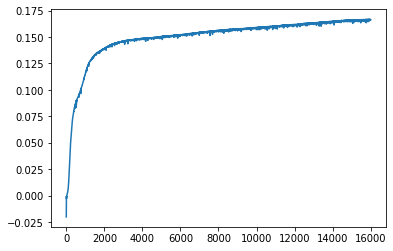

In [ ]:
extra = 4000
for epoch in tqdm(range(num_epoch,num_epoch+extra)):
    pred_xy = model(S_sample, w_sample)
    pred_x_y = model(S_sample, w_shuffle_sample)
    
    loss1 = - torch.mean(pred_xy)
    t1 = solve_f_star(pred_x_y).reshape((-1,1))
    loss2 = torch.mean(t1*pred_x_y)
    loss2_actual = torch.mean(t1-1+torch.log(t1))
    loss = loss1 + loss2
    skl.append((-loss1-loss2_actual).data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

x_plot = [x for x in range(num_epoch+extra)]
plt.plot(x_plot, skl)
skl[len(skl)-1]